### 데이터 정보
- column : timestamp, Q, M, P, P_flag, anomlay
- timestamp : 1분단위
- Q1 ~ Q5 : 유량(int, float)
- M1 ~ M14 : 펌프가동여부(binary)
- P1 ~ P26 : 압력(float)
- anomaly : 이상탐지여부
- P1 ~ P26_flag : 압력계이상여부(binary)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


train_a = pd.read_csv("./train/TRAIN_A.csv")
train_b = pd.read_csv("./train/TRAIN_B.csv")

In [3]:
adjacency_list_A = {
    'P1' :  [['P5','P6'], [], ['Q1']],
    'P2' :  [['P4'], [], ['Q3']],
    'P3' :  [['P5','P6'], ['Q2'], ['Q5']],
    'P4' :  [['P5','P6'], ['Q3'], ['Q5']],
    'P5' :  [['P8','P9'], ['Q1','Q2','Q3'], ['Q5']],
    'P6' :  [['P8','P9'], ['Q1','Q2','Q3'], ['Q5']],
    'P7' :  [['P9'], ['Q4'], ['Q5']],
    'P8' :  [['P10','P12','P19','P26'], ['Q1','Q2','Q3'], ['Q5']],
    'P9' :  [['P10','P12','P19','P26'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P10':  [['P11'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P11':  [['P14'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P12':  [['P13'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P13':  [['P18','P14'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P14':  [['P13','P15'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P15':  [['P16'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P16':  [['P17','P19'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P17':  [[], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P18':  [['P19','P20'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P19':  [['P18','P22','P26'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P20':  [['P21'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P21':  [['P24'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P22':  [['P23'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P23':  [['P25'], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P24':  [[], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P25':  [[], ['Q1','Q2','Q3','Q4'], ['Q5']],
    'P26':  [[], ['Q1','Q2','Q3','Q4'], ['Q5']]
}
nodes_A = list(adjacency_list_A.keys())

adjacency_list_B = {
    'P1': [['P2'], [], ['Q1']],
    'P2': [['P3'], ['Q1'], ['Q2','Q3','Q4']],
    'P3': [['P4','P5'], ['Q1'], ['Q2','Q3','Q4']],
    'P4': [[], ['Q1'], ['Q2']],
    'P5': [['P6'], ['Q1'], ['Q3','Q4']],
    'P6': [['P7','P8'], ['Q1'], ['Q3','Q4']],
    'P7': [[], ['Q1'], ['Q3']],
    'P8': [['P9'], ['Q1'], ['Q4']],
    'P9': [['P10'], ['Q1'], ['Q4']],
    'P10': [[], ['Q1'], ['Q4']]
}
nodes_B = list(adjacency_list_B.keys())

adjacency_list_C = {
    'P1':  [['P3'], ['Q1'], ['Q2','Q3','Q4','Q5','Q8']],
    'P2':  [['P4'], ['Q1'], ['Q2','Q3','Q4','Q5','Q8']],
    'P3':  [['P5','P8'], ['Q1'], ['Q2','Q3','Q4','Q5','Q8']],
    'P4':  [['P5','P8'], ['Q1'], ['Q2','Q3','Q4','Q5','Q8']],
    'P5':  [[], ['Q1'], ['Q2','Q3','Q4','Q5']],
    'P6':  [[], ['Q1'], ['Q2','Q3','Q4','Q5']],
    'P7':  [[], ['Q7'], []],
    'P8':  [[], ['Q8'], []]
}
nodes_C = list(adjacency_list_C.keys())

adjacency_list_D = {
    'P1':  [['P3'], ['Q1'], ['Q2','Q3','Q4','Q5']],
    'P2':  [['P3'], ['Q1'], ['Q2','Q3','Q4','Q5']],
    'P3':  [['P4','P6'], ['Q1'], ['Q3','Q5']],
    'P4':  [[], ['Q3'], []],
    'P5':  [[], ['Q1'], ['Q4']],
    'P6':  [[], ['Q1'], ['Q5']]
}
nodes_D = list(adjacency_list_D.keys())

## M - Q 관계성 확인
TRAIN_A 사용

In [4]:
from scipy.stats import pointbiserialr

binary_columns = [f"M{i}" for i in range(1, 15)]
continuous_columns = [f"Q{i}" for i in range(1, 6)]

correlation_results = []

for m_col in binary_columns:
    for q_col in continuous_columns:
        correlation, p_value = pointbiserialr(train_a[m_col], train_a[q_col])
        correlation_results.append({"Binary": m_col, "Continuous": q_col, "Correlation": correlation, "P-value": p_value})

correlation_df = pd.DataFrame(correlation_results)
correlation_df_sorted = correlation_df.sort_values(by="Continuous")

df = correlation_df_sorted[correlation_df_sorted['P-value'].notnull()]
df = df[abs(df['Correlation']) > 0.5]
df = df.groupby('Continuous')['Binary'].unique()
df

D:\anaconda\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Continuous
Q1         [M5]
Q2    [M12, M6]
Q3    [M12, M5]
Name: Binary, dtype: object

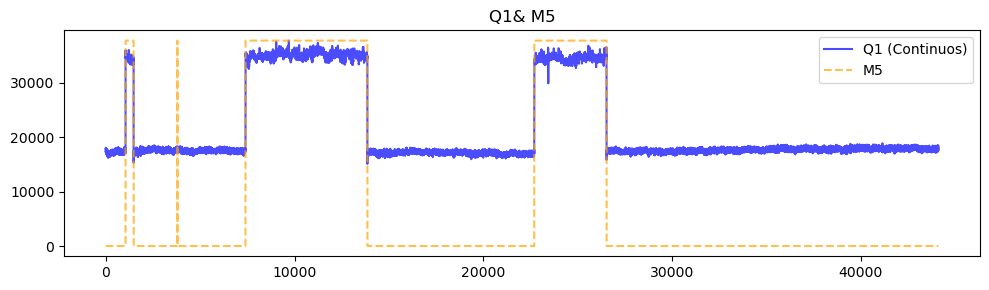

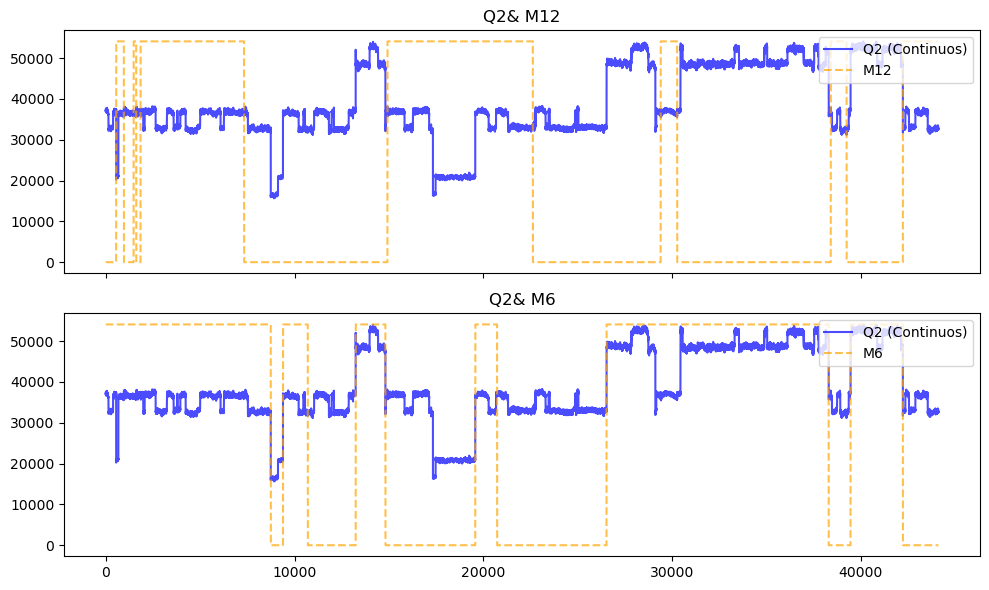

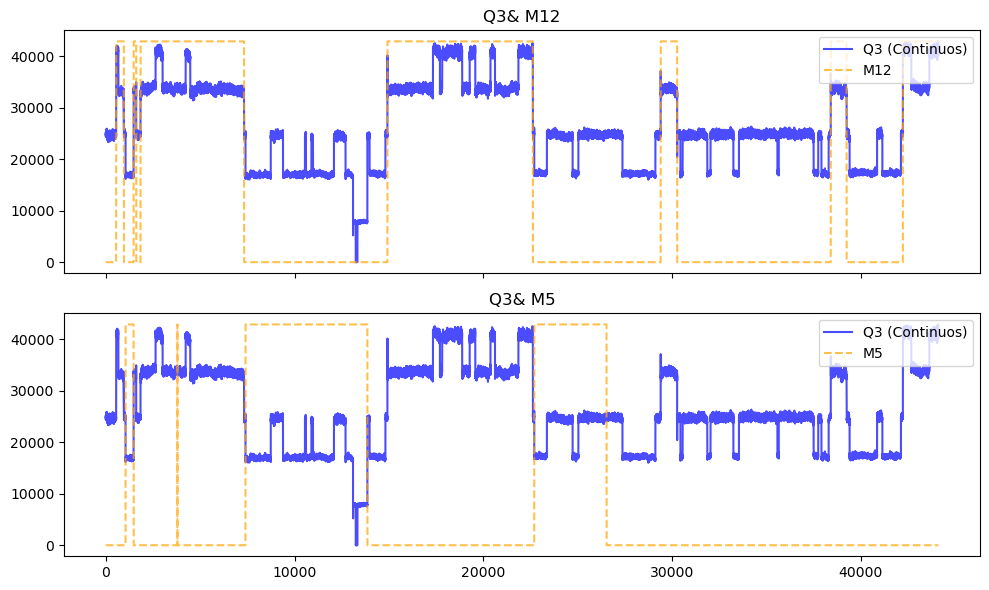

In [5]:
import matplotlib.pyplot as plt

# Q - M 매핑
q_to_m = {
    'Q1': ['M5'],
    'Q2': ['M12', 'M6'],
    'Q3': ['M12', 'M5']
}


for q_col, m_cols in q_to_m.items():
    fig, axes = plt.subplots(len(m_cols), 1, figsize=(10, len(m_cols) * 3), sharex=True)
    
    for i, m_col in enumerate(m_cols):
        
        axes[i].plot(train_a[q_col], label=f"{q_col} (Continuos)", color="blue", alpha=0.7)
        axes[i].plot(train_a[m_col] * train_a[q_col].max(), label=m_col, linestyle="--", color="orange", alpha=0.7)
        axes[i].set_title(f"{q_col}& {m_col}")
        axes[i].legend(loc="upper right")

    plt.tight_layout()
    plt.show()


## P - Q 관계성 확인 (이상구간)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

def define_q_flow(df, dataset_type):
    
    if dataset_type.lower() == 'train_a':
        
        df["Q_in"] = df[["Q1", "Q2", "Q3", "Q4"]].sum(axis=1)
        df["Q_out"] = df["Q5"]
    elif dataset_type.lower() == 'train_b':
        # 유입 : Q1
        # 유출 : Q2, Q3, Q4
        df["Q_in"] = df["Q1"]
        df["Q_out"] = df[["Q2", "Q3", "Q4"]].sum(axis=1)
    else:
        raise ValueError("dataset_type must be either 'train_a' or 'train_b'")
    
    # Q_diff = 유입 - 유출
    df["Q_diff"] = df["Q_in"] - df["Q_out"]
    return df

def plot_t_square_with_smoothing(
    df, 
    dataset_type, 
    p_cols, 
    anomaly_col="anomaly",
    alpha=0.05,
    title="T-square Control Chart (Smoothed)",
    window_size=10
):
    
    df = define_q_flow(df, dataset_type)
    feature_cols = p_cols + ["Q_diff"]  
    X = df[feature_cols].values
    n_samples, n_features = X.shape
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    cov_inv = np.linalg.inv(cov)
    
    
    T2_values = []
    for i in range(n_samples):
        x_i = X[i, :]
        diff = (x_i - mu).reshape(-1, 1)
        T2 = float(diff.T @ cov_inv @ diff)
        T2_values.append(T2)
    
    df["T2_value"] = T2_values
    
    threshold = chi2.ppf(1 - alpha, df=n_features)
    anomalies = (df[anomaly_col] == 1)
    df["T2_value_smooth"] = df["T2_value"].rolling(window=window_size, min_periods=1).mean()
    
    df["Q_in_smooth"] = df["Q_in"].rolling(window=window_size, min_periods=1).mean()
    df["Q_out_smooth"] = df["Q_out"].rolling(window=window_size, min_periods=1).mean()
    
    p_mean = df[p_cols].mean(axis=1)  
    df["P_mean"] = p_mean  
    df["P_mean_smooth"] = p_mean.rolling(window=window_size, min_periods=1).mean()
    
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    # T-square
    axes[0].plot(df.index, df["T2_value"], label="T2 (raw)", color='lightblue', alpha=0.5)
    axes[0].plot(df.index, df["T2_value_smooth"], label=f"T2 (rolling={window_size})", color='blue')
    axes[0].axhline(y=threshold, color='red', linestyle='--', label=f"Threshold({alpha})")

    axes[0].scatter(
        df.index[anomalies], 
        df.loc[anomalies, "T2_value_smooth"], 
        color='red', 
        label='Anomaly=1', 
        marker='o'
    )
    axes[0].set_ylabel("T-square")
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(df.index, df["Q_in_smooth"], label=f"Q_in (rolling={window_size})", color='green')
    axes[1].plot(df.index, df["Q_out_smooth"], label=f"Q_out (rolling={window_size})", color='orange')

    axes[1].scatter(df.index[anomalies], 
                    df.loc[anomalies, "Q_in_smooth"], 
                    color='red', marker='o')
    axes[1].scatter(df.index[anomalies], 
                    df.loc[anomalies, "Q_out_smooth"], 
                    color='red', marker='o')
    axes[1].set_ylabel("Q_in / Q_out (smooth)")
    axes[1].legend()
    axes[1].grid(True)
    
    # (하단) P_mean (smoothed)
    axes[2].plot(df.index, df["P_mean_smooth"], label=f"P_mean (rolling={window_size})", color='purple')
    # anomaly=1 지점
    axes[2].scatter(df.index[anomalies], 
                    df.loc[anomalies, "P_mean_smooth"], 
                    color='red', marker='o')
    axes[2].set_ylabel("Mean(P) (smooth)")
    axes[2].legend()
    axes[2].grid(True)
    
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()
    
    return df


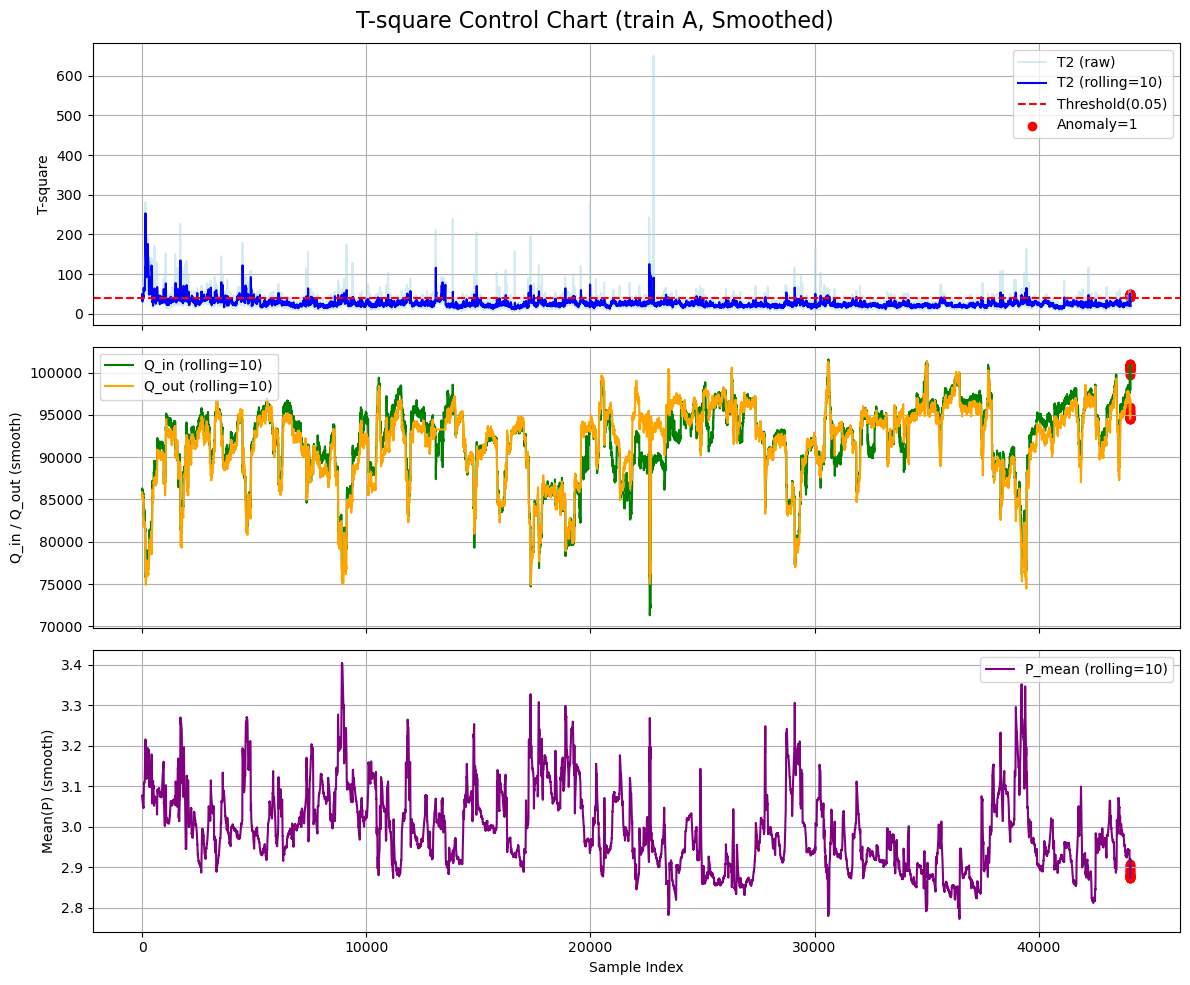

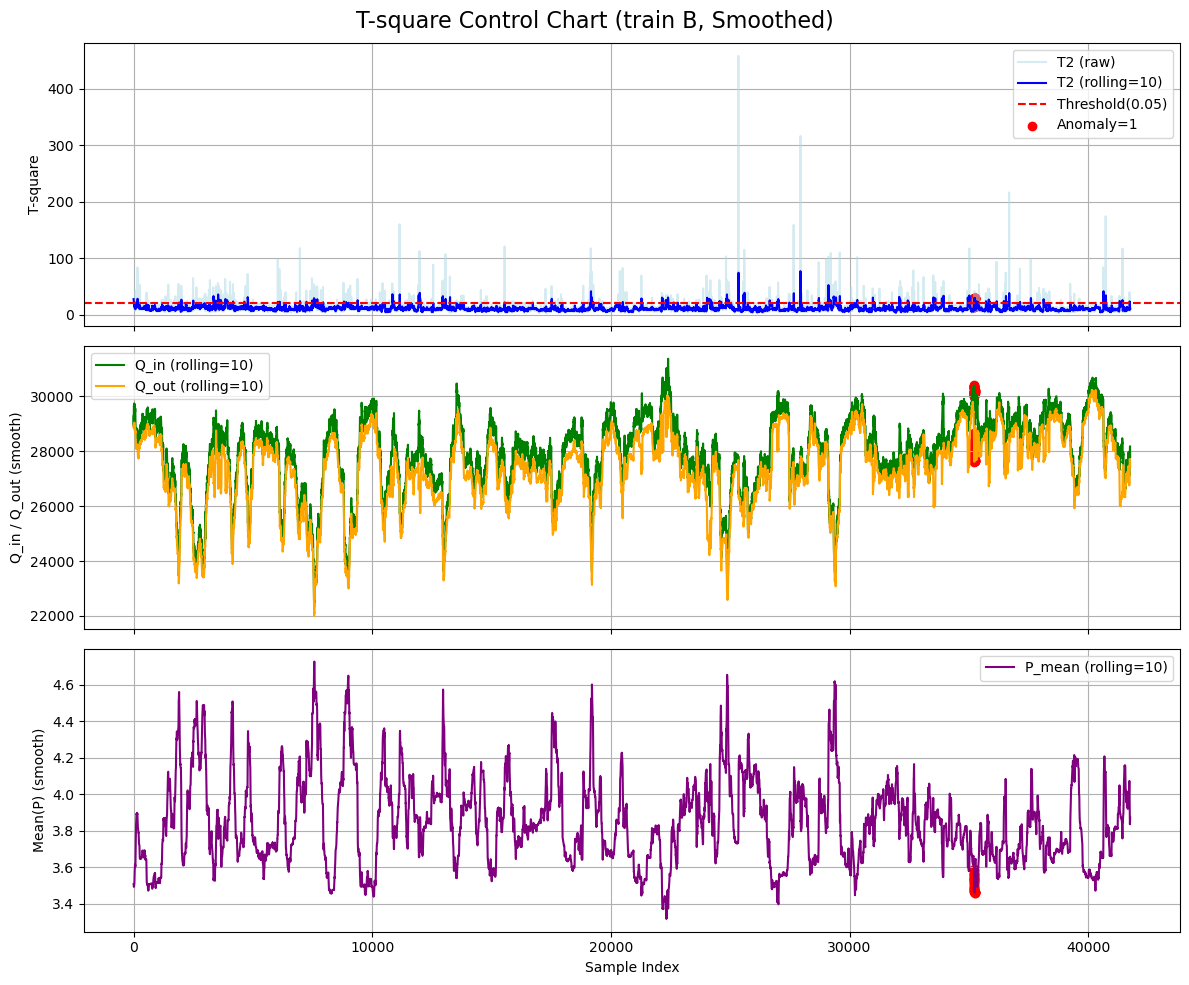

In [18]:
# A
train_a_result = plot_t_square_with_smoothing(
    df=train_a, 
    dataset_type="train_a",
    p_cols=[f"P{i}" for i in range(1, 27)],
    anomaly_col="anomaly",
    alpha=0.05,
    title="T-square Control Chart (train A, Smoothed)",
    window_size=10
)

# B
train_b_result = plot_t_square_with_smoothing(
    df=train_b, 
    dataset_type="train_b",
    p_cols=[f"P{i}" for i in range(1, 11)],
    anomaly_col="anomaly",
    alpha=0.05,
    title="T-square Control Chart (train B, Smoothed)",
    window_size=10
)
